## Setup the default forcing

In [1]:
from matplotlib import rc
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
os.chdir("/home/149/ab8992/topographic-NIWs")
basepath = Path.cwd().absolute()

import autolib as al
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42665,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:45279,Total threads: 4
Dashboard: /proxy/45371/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:46841,


In [2]:
eslice200km = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/rundirs/strength/strength_2/archive/*/e.nc",decode_times = False,decode_cf = False).sel(yh = slice(-1000,1000))

eslice200km = (eslice200km.sel(xh = 200,method = "nearest") - eslice200km.isel(xh = 0)).load()

uslice200km = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/rundirs/strength/strength_2/archive/*/u.nc",decode_times = False,decode_cf = False).sel(yh = slice(-1000,1000))

uslice200km = (uslice200km.sel(xq = 200,method = "nearest") - uslice200km.isel(xq = 0)).load()

xr.merge([eslice200km,uslice200km]).to_netcdf("/home/149/ab8992/topographic-NIWs/test_wideintegration.nc")

In [35]:
emerid = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/rundirs/strength/strength_2/archive/*/e.nc",decode_times = False,decode_cf = False).sel(yh = slice(0,500)).isel(xh = 0).load()
vmerid = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/rundirs/strength/strength_2/archive/*/v.nc",decode_times = False,decode_cf = False).sel(yq = slice(0,500)).isel(xh = 0).interp(yq = emerid.yh).load()
xr.merge([emerid,vmerid]).to_netcdf("/home/149/ab8992/topographic-NIWs/test_wideintegration_merid.nc")

## Check default model run outputs

In [41]:
import xrft

def sup_filter(field):
    f = 0.0001 / (np.pi * 2)
    FIELD = xrft.fft(field.load(),dim = "time")
    FIELD_filtered = FIELD.where(np.abs(FIELD.freq_time) > 1.2 * f,0)
    return np.real(xrft.ifft(FIELD_filtered,dim = "freq_time"))

def get_energy_fluxes(data, zonal = True):

    ### Get the data

    u = "v"
    if zonal:
        u = "u"

    ## Calculate anomalies for the zonal part
    zon_pressure = al.calculate_pressure(data.e,data[u].zl)

    zpf = sup_filter(zon_pressure)
    zuf = sup_filter(data[u])

    zpf = zon_pressure
    zuf = data[u]

    # merid_pressure_anom = merid_pressure - merid_pressure.isel(yh = -1)

    zon_EF = (zuf * zpf).isel(zl = slice(0,None))
    
    return zon_EF

In [42]:
ef = get_energy_fluxes(xr.merge([eslice200km.e.rename("e"),uslice200km.u.rename("u")]))
ef_merid = get_energy_fluxes(xr.merge([emerid.e.rename("e"),vmerid.v.rename("v")]),zonal = False)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/

In [8]:
np.max(ef)

<xarray.DataArray ()> Size: 8B
array(0.01402376)

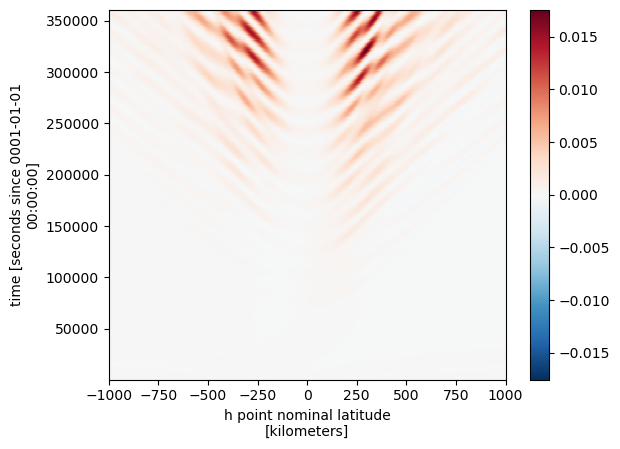

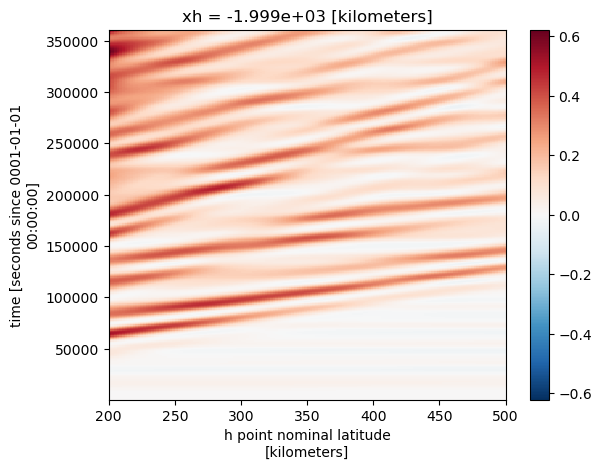

In [51]:
ef.sum("zl").plot()
plt.figure()
ef_merid.sum("zl").sel(yh = slice(200,None)).plot()

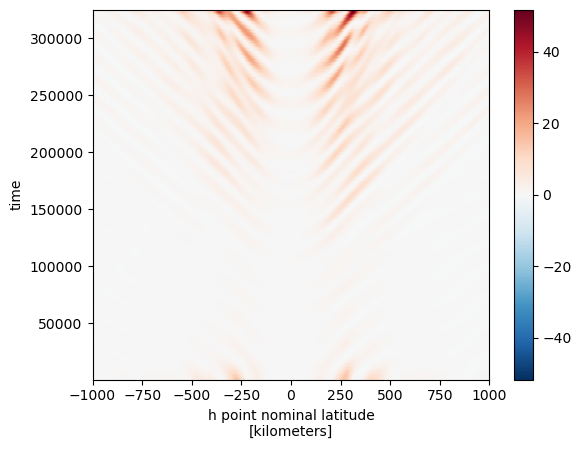

In [39]:
ef.plot()

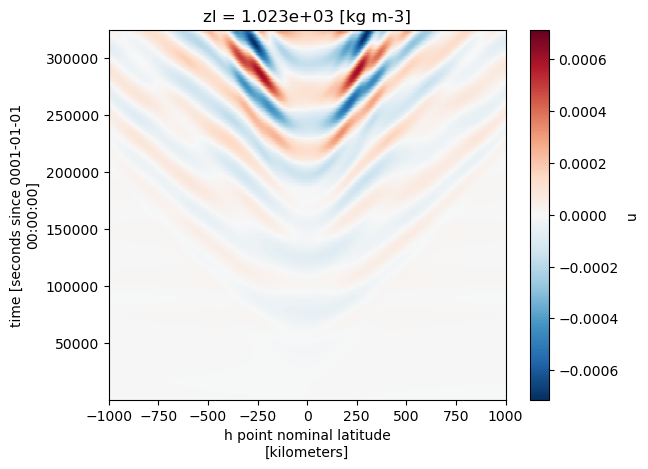

In [41]:
uslice200km.u.isel(zl = 5).plot()

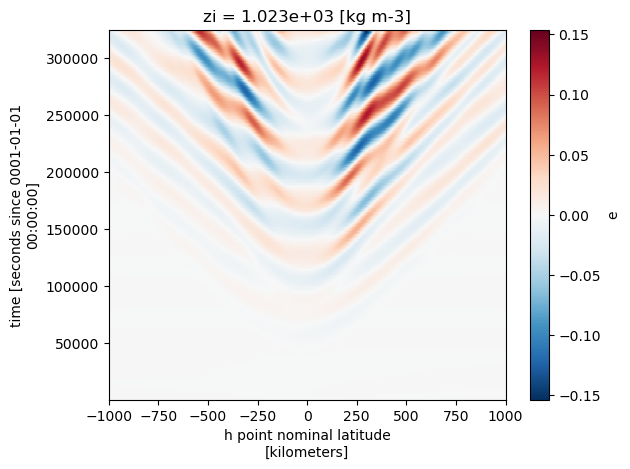

In [42]:
eslice200km.e.isel(zi = 5).plot()


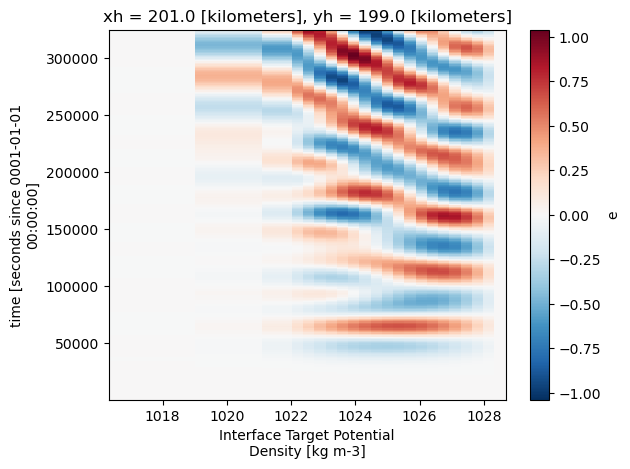

In [18]:
(eslice200km - eslice200km.isel(time = 0)).e.sel(yh = 200,method = "nearest").plot()


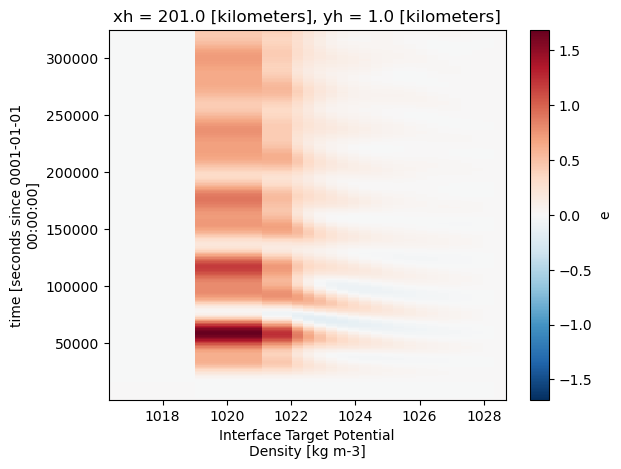

In [22]:
(eslice200km - eslice200km.isel(time = 0)).e.sel(yh = 0,method = "nearest").plot()


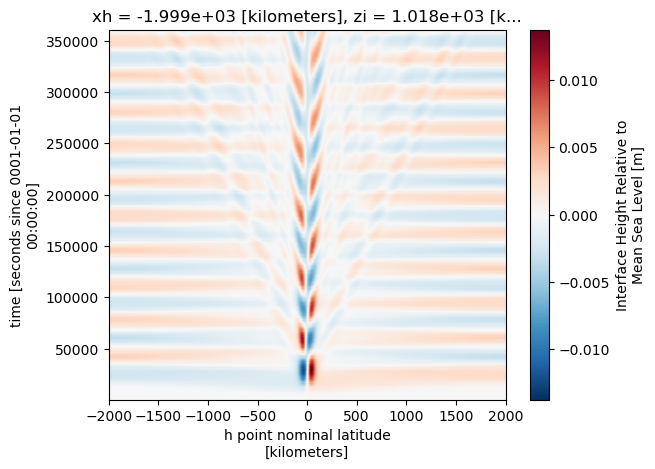

In [50]:
ereflection = xr.open_mfdataset("/home/149/ab8992/topographic-NIWs/rundirs/strength/strength_2/archive/*/e.nc",decode_times = False,decode_cf = False).isel(xh = 0)

ereflection.isel(zi = 0).e.plot()
